In [34]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image, ImageDraw
import pandas as pd
import numpy as np
import cv2
import os

In [3]:
#  load all images from a directory
def load_images_from_folder(folder):
    images = []
    filenames = []
    for filename in tqdm(os.listdir(folder)):
        try:
            img = Image.open(os.path.join(folder,filename))
            if img is not None:
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                images.append(img)
                filenames.append(filename)
        except Exception as e:
            print(e)
    return images, filenames

In [4]:
# load all jsons from a directory
def load_jsons_from_folder(folder):
    jsons = []
    filenames = []
    for filename in tqdm(os.listdir(folder)):
        try:
            json = pd.read_json(os.path.join(folder,filename))
            if json is not None:
                jsons.append(json)
                filenames.append(filename)
        except Exception as e:
            print(e)
    return jsons, filenames

In [5]:
human_parsing = load_images_from_folder('Task/dataset/human_parsing')
image = load_images_from_folder('Task/dataset/image')
pose_img = load_images_from_folder('Task/dataset/pose_img')
pose_json = load_jsons_from_folder('Task/dataset/pose_json')

100%|██████████| 705/705 [00:00<00:00, 2504.53it/s]

cannot identify image file 'Task/dataset/image\\.DS_Store'



100%|██████████| 704/704 [00:01<00:00, 379.82it/s]


In [6]:
df = pd.DataFrame()
df['human_parsing'] = human_parsing[0]
df['image'] = image[0]
df['pose_img'] = pose_img[0]
df['pose_json'] = pose_json[0]

In [7]:
# assert all(human_parsing[1] == image[1] == pose_img[1])
df_names = pd.DataFrame()
df_names['human_parsing'] = human_parsing[1]
df_names['image'] = image[1]
df_names['pose_img'] = pose_img[1]
df_names['pose_json'] = pose_json[1]

In [8]:
def show_images_df(df, index):
    fig, axs = plt.subplots(1, 3, figsize=(20, 20))
    axs[0].imshow(df['human_parsing'][index])
    axs[1].imshow(df['image'][index])
    axs[2].imshow(df['pose_img'][index])

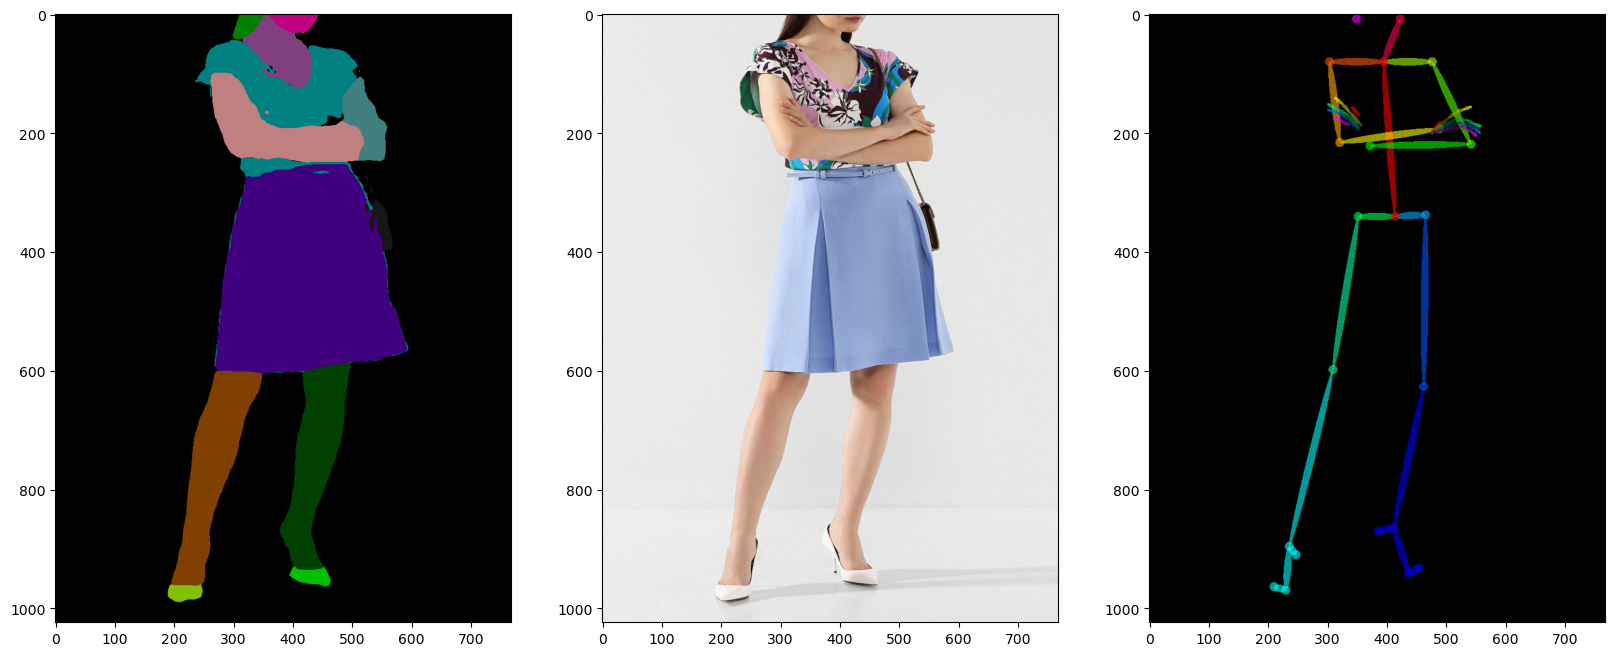

In [9]:
show_images_df(df, 0)

In [11]:
df['pose_keypoints'] = df.pose_json.apply(lambda x: x.people[0].get('pose_keypoints_2d'))

In [13]:
# draw circles for each dot in poses and add annotation with number of big size
def draw_pose(img, poses):
    draw = ImageDraw.Draw(img)
    for i in range(0, len(poses), 3):
        draw.ellipse((poses[i]-5, poses[i+1]-5, poses[i]+5, poses[i+1]+5), fill=(255, 0, 0, 255))
        draw.text((poses[i], poses[i+1]), str(i//3), fill=(255, 255, 255, 255))
    return img

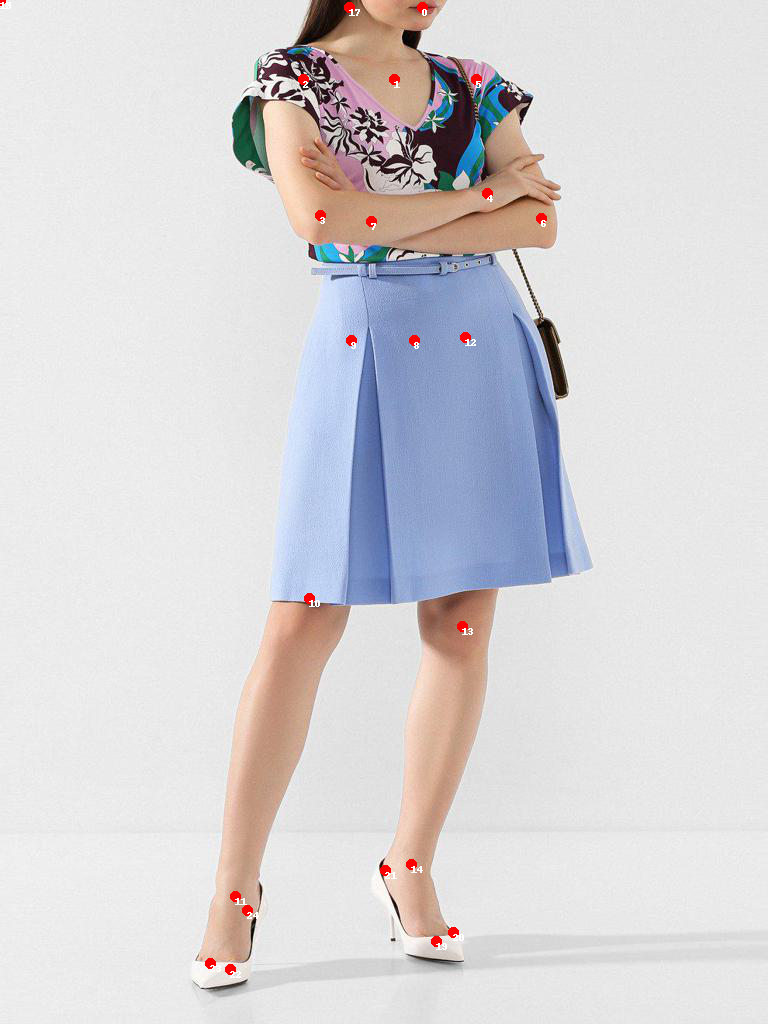

In [14]:
draw_pose(df.image[0], df.pose_keypoints[0])

In [15]:
short_colors = ((64, 0, 128), (192, 0, 0))
short_colors

((64, 0, 128), (192, 0, 0))

In [22]:
def get_shorts_mask(img, colors):
    img = np.array(img)
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    for color in colors:
        mask += np.all(img == color, axis=-1).astype(np.uint8)
    return mask

(<matplotlib.image.AxesImage at 0x188930c76d0>,
 <matplotlib.image.AxesImage at 0x188930f1fc0>)

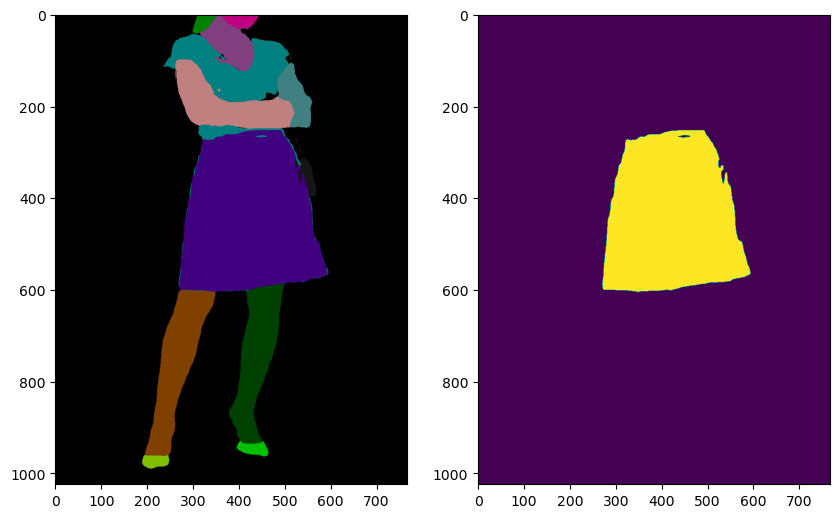

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow(df.human_parsing[0]), axs[1].imshow(get_shorts_mask(df.human_parsing[0], short_colors))

In [32]:
# return tuple of (left_high, left_low, right_high, right_low)
def get_shorts_coords(mask):
    mask = np.array(mask)
    mask = mask.astype(np.uint8)
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    left_high = tuple(cnt[cnt[:,:,1].argmin()][0])
    left_low = tuple(cnt[cnt[:,:,1].argmax()][0])
    right_high = tuple(cnt[cnt[:,:,0].argmax()][0])
    right_low = tuple(cnt[cnt[:,:,0].argmin()][0])
    return left_high, left_low, right_high, right_low

In [35]:
mask = get_shorts_mask(df.human_parsing[0], short_colors)
get_shorts_coords(mask)

((434, 253), (347, 605), (592, 565), (270, 587))